In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
batch_size = 16
image_size = 350

save_model_filename = 'inception_(0).h5'

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

In [4]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [5]:
train['label'] = train['label'].astype('str')

In [6]:
image_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                validation_split=0.2, rescale = 1./255)

test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                subset='training', batch_size=batch_size, seed=1,
                                                shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

validation_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', batch_size=batch_size, seed=1,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [8]:
def build_inceptionV3():
    model = Sequential()
    model.add(InceptionV3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [9]:
model = build_inceptionV3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 9, 9, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


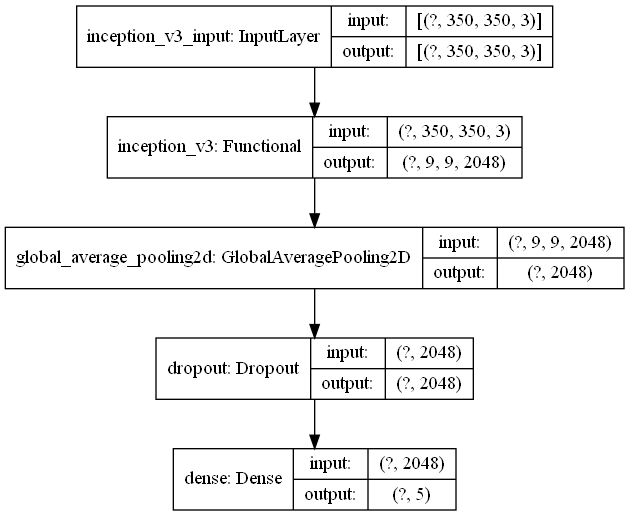

In [10]:
plot_model(model, to_file='inceptionV3.png', show_shapes=True)

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=1, min_lr=0, verbose=1)

In [13]:
epoch = 30

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.7527
Epoch 00001: val_loss improved from inf to 1.19003, saving model to inception_(0).h5
1070/1070 [==============================] - 594s 556ms/step - loss: 0.7066 - accuracy: 0.7527 - val_loss: 1.1900 - val_accuracy: 0.5403
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.8080
Epoch 00002: val_loss did not improve from 1.19003

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1070/1070 [==============================] - 522s 487ms/step - loss: 0.5550 - accuracy: 0.8080 - val_loss: 1.5731 - val_accuracy: 0.2769
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8458
Epoch 00003: val_loss improved from 1.19003 to 0.44141, saving model to inception_(0).h5
1070/1070 [==============================] - 522s 487ms/step - loss: 0.4477 - accuracy: 0.8458 - val_loss: 0.4414 - val_accura

train loss: 0.36864376068115234
train accuracy: 0.8758032321929932
dev loss: 0.39622002840042114
dev accuracy: 0.8639869093894958


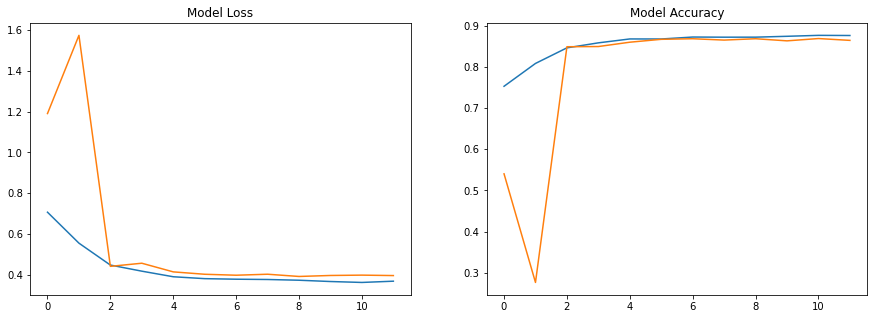

In [14]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [15]:
pred = model.predict(validation_generator)
predictions = np.argmax(pred, axis=1)
actual = validation_generator.classes

from sklearn.metrics import classification_report

report = classification_report(actual, predictions, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

              precision    recall  f1-score   support

         CBB       0.55      0.60      0.57       200
        CBSD       0.81      0.75      0.78       436
         CGM       0.83      0.73      0.78       495
         CMD       0.95      0.96      0.96      2638
     Healthy       0.66      0.72      0.69       510

    accuracy                           0.87      4279
   macro avg       0.76      0.75      0.75      4279
weighted avg       0.87      0.87      0.87      4279



In [16]:
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [17]:
test_path = '../input/cassava-leaf-disease-classification/test_images'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [24]:
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.inception_v3.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 1 validated image filenames belonging to 1 classes.


In [25]:
output = model.predict(test_generator)

In [26]:
submission = pd.DataFrame()
submission['image_id'] = list(os.listdir(test_path))
submission['label'] = np.argmax(output, axis=1)
submission.to_csv("submission.csv", index=False)

In [27]:
submission.head()

,image_id,label
0,2216849948.jpg,2


In [28]:
model.save('model_inception_final.h5')

In [29]:
model.save_weights('inception_weights')